In [3]:
import pandas as pd
import numpy as np
from datasets import load_dataset
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
finer_full_dataset = load_dataset("nlpaueb/finer-139")
finer_train_df = finer_full_dataset['train'].to_pandas()
finer_test_df = finer_full_dataset['test'].to_pandas()
finer_validation_df = finer_full_dataset['validation'].to_pandas()

In [20]:
feature_names = finer_full_dataset['train'].features['ner_tags'].feature.names

### Initial observations
1. From the [dataset card](https://huggingface.co/datasets/nlpaueb/finer-139#initial-data-collection-and-normalization) we see that the dataset follows the IOB2 format. 
2. The IOB2 format, indicates that the Entities that start with `B` are the the beginning of the tag, Those with `I` are in the middle of the tag and `O` is outside the tag.

<Axes: xlabel='tokens', ylabel='Count'>

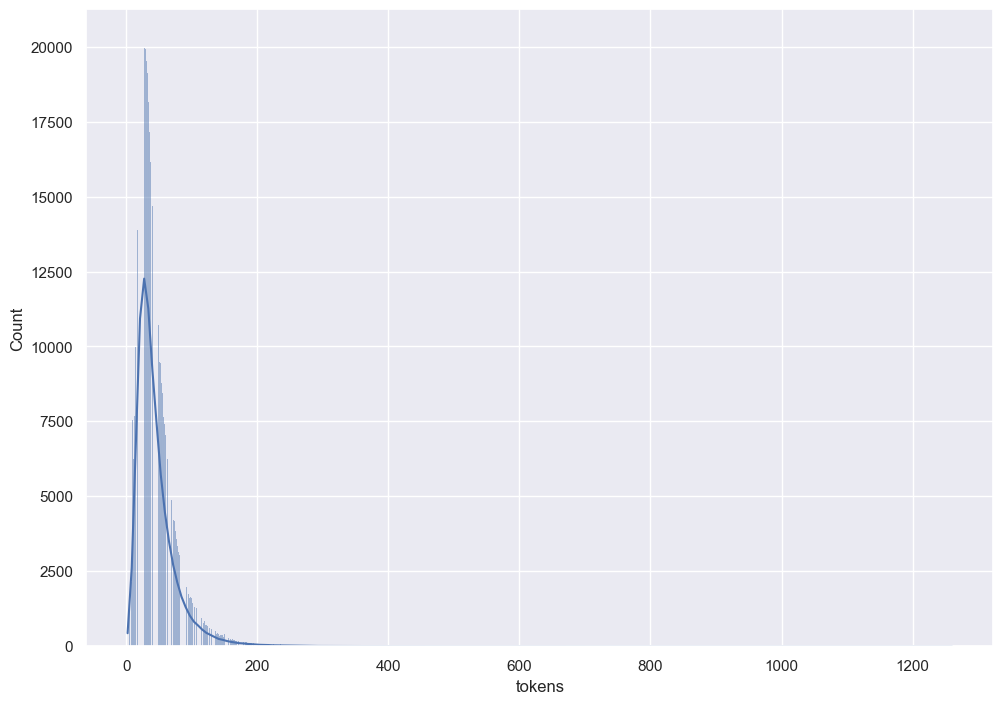

In [17]:
token_lengths = finer_train_df.tokens.apply(len)
sns.histplot(token_lengths, kde=True)


In [4]:
medians = np.median(token_lengths)
means = np.average(token_lengths)
print(f'median: {medians}')
print(f'Average value: {means}')

median: 37.0
Average value: 45.34454077371433


#### Observstions
As seen from the distribution as well as the mean and the median most tokens have a length below 50.

In [39]:
fn_dict = dict(enumerate(feature_names))
finer_train_df['tag_names'] = finer_train_df.ner_tags.apply(np.unique).apply(lambda x: [ fn_dict[i] for i in x])

In [91]:
train_tag_frequencies_df = finer_train_df.explode('tag_names').tag_names.value_counts().reset_index()
train_tag_frequencies_df

,tag_names,count
0,O,900384
1,B-DebtInstrumentInterestRateStatedPercentage,10503
2,B-LineOfCreditFacilityMaximumBorrowingCapacity,8589
3,B-DebtInstrumentFaceAmount,8294
4,B-DebtInstrumentBasisSpreadOnVariableRate1,5336
...,...,...
163,I-TreasuryStockSharesAcquired,2
164,I-RelatedPartyTransactionAmountsOfTransaction,1
165,I-DebtInstrumentFaceAmount,1
166,I-EquityMethodInvestmentOwnershipPercentage,1


### Observation
Simply observing the dataframe tells us that the `O` tag name will skew the dataset sine it occurs significantly more than any opf the others. Therefore we will explore the dataset excluding this tag since we know it is hihgly prevalent

In [100]:
train_tag_frequencies_df = train_tag_frequencies_df[train_tag_frequencies_df['tag_names'] != 'O']
_, bins = pd.cut(train_tag_frequencies_df['count'].to_list(), 10, retbins=True)

In [101]:
bins

array([-9.5020e+00,  1.0512e+03,  2.1014e+03,  3.1516e+03,  4.2018e+03,
        5.2520e+03,  6.3022e+03,  7.3524e+03,  8.4026e+03,  9.4528e+03,
        1.0503e+04])

<Axes: xlabel='Count', ylabel='count'>

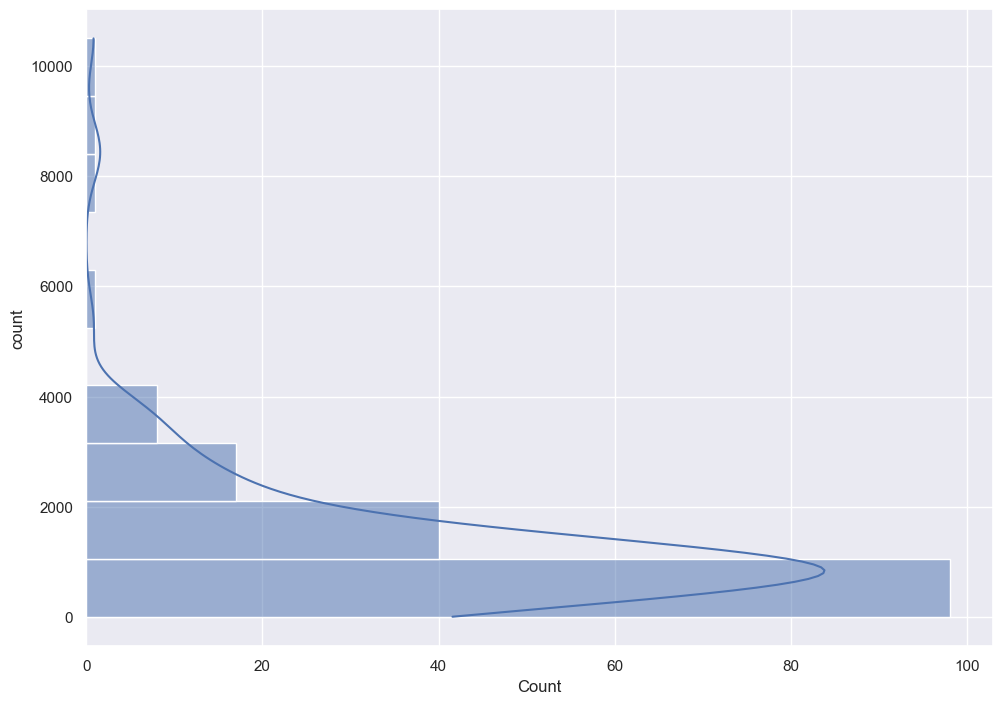

In [115]:
sns.histplot(train_tag_frequencies_df,
            y='count', 
            bins=bins, 
            kde=True)

In [162]:
b_i_df = train_tag_frequencies_df.tag_names.apply(lambda name: (name.startswith('B'), name.startswith('I'))).apply(pd.Series)
b_i_df.columns = ['begin', 'inside']

In [170]:
train_tag_frequencies_df = train_tag_frequencies_df.join(b_i_df, how='inner')

In [172]:
train_tag_frequencies_df.begin.value_counts()

begin
True     139
False     28
Name: count, dtype: int64

#### Observation
Most of the tags are of the type `Begin`

In [185]:
train_tag_frequencies_df[train_tag_frequencies_df.inside]

,tag_names,count,begin,inside
27,I-ShareBasedCompensationArrangementByShareBase...,2181,False,True
51,I-DebtInstrumentMaturityDate,1239,False,True
125,I-LesseeOperatingLeaseTermOfContract,623,False,True
137,I-SharebasedCompensationArrangementBySharebase...,504,False,True
139,I-LesseeOperatingLeaseRenewalTerm,490,False,True
142,I-DebtInstrumentTerm,463,False,True
146,I-FiniteLivedIntangibleAssetUsefulLife,390,False,True
147,I-AcquiredFiniteLivedIntangibleAssetsWeightedA...,297,False,True
148,I-PropertyPlantAndEquipmentUsefulLife,240,False,True
149,I-EmployeeServiceShareBasedCompensationNonvest...,231,False,True


#### Observation
We see that the tags for which correspond to tokens that are not at the beginning (i.e. inside) the entity are quite sparse.

In [183]:
train_tag_frequencies_df[train_tag_frequencies_df.tag_names.apply(lambda n: 'ShareBasedCompensationArrangementByShareBasedPaymentAwardAwardVestingPeriod1' in n)]

,tag_names,count,begin,inside
21,B-ShareBasedCompensationArrangementByShareBase...,2507,True,False
27,I-ShareBasedCompensationArrangementByShareBase...,2181,False,True


In [184]:
train_tag_frequencies_df[train_tag_frequencies_df.tag_names.apply(lambda n: 'DebtInstrumentMaturityDate' in n)]

,tag_names,count,begin,inside
51,I-DebtInstrumentMaturityDate,1239,False,True
52,B-DebtInstrumentMaturityDate,1239,True,False


#### Observation
The `inside` tags do have corersponding `Begin` tags and are fairly balanced (as they should be) with those

In [202]:
tag_integers = []
for t in ['B-ShareBasedCompensationArrangementByShareBasedPaymentAwardAwardVestingPeriod1',
        'I-ShareBasedCompensationArrangementByShareBasedPaymentAwardAwardVestingPeriod1',
        'B-DebtInstrumentMaturityDate',
        'I-DebtInstrumentMaturityDate']:
    tag_integers.append(feature_names.index(t))

In [204]:
train_subset_df = finer_train_df[finer_train_df.ner_tags.apply(lambda i: any( t in i for t in tag_integers))]

In [205]:
train_subset_df

,tokens,ner_tags,tag_names
1707,"[The, borrowing, period, for, the, Subordinate...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 42, 43, 43, ...","[O, B-DebtInstrumentMaturityDate, I-DebtInstru..."
2694,"[The, option, expires, in, 10, years, and, ves...","[0, 0, 0, 0, 154, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","[O, B-ShareBasedCompensationArrangementByShare..."
3749,"[RSUs, vest, annually, on, a, cliff, basis, ov...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[O, B-ShareBasedCompensationArrangementByShare..."
4108,"[Share, -, based, compensation, expense, for, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[O, B-ShareBasedCompensationArrangementByShare..."
4265,"[The, performance, -, based, restricted, stock...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[O, B-ShareBasedCompensationArrangementByShare..."
...,...,...,...
900158,"[The, awards, with, service, conditions, gener...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 138, 139, 0, 0, 0,...","[O, B-ShareBasedCompensationArrangementByShare..."
900159,"[Market, performance, -, based, awards, cliff,...","[0, 0, 0, 0, 0, 0, 0, 0, 138, 139, 0, 0, 0, 0,...","[O, B-ShareBasedCompensationArrangementByShare..."
900160,"[Operating, performance, -, based, awards, cli...","[0, 0, 0, 0, 0, 0, 0, 0, 138, 139, 0, 0, 0, 0,...","[O, B-ShareBasedCompensationArrangementByShare..."
900291,"[The, options, had, graded, vesting, over, thr...","[0, 0, 0, 0, 0, 0, 138, 139, 0, 0, 0, 0, 0, 0,...","[O, B-ShareBasedCompensationArrangementByShare..."


In [206]:
test_subset_df = finer_test_df[finer_test_df.ner_tags.apply(lambda i: any( t in i for t in tag_integers))]

In [207]:
test_subset_df

,id,tokens,ner_tags
916,1013794,"[The, SRT, Loan, matures, on, January, 9, ,, 2...","[0, 0, 0, 0, 0, 42, 43, 43, 43, 0]"
929,1013807,"[The, Wilshire, Loan, is, scheduled, to, matur...","[0, 0, 0, 0, 0, 0, 0, 0, 42, 43, 43, 43, 0, 0,..."
934,1013812,"[The, new, maturity, date, is, October, 31, ,,...","[0, 0, 0, 0, 0, 42, 43, 43, 43, 0]"
1494,1014372,"[Generally, ,, stock, options, granted, have, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 154, 155, 0,..."
1635,1014513,"[Of, the, 238,500, grants, awarded, in, 2020, ...","[0, 0, 149, 0, 0, 0, 0, 0, 149, 0, 0, 0, 0, 0,..."
...,...,...,...
107183,1120061,"[Restricted, stock, units, generally, vest, ,,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 152..."
107434,1120312,"[Accordingly, ,, the, vesting, of, restricted,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
107963,1120841,"[Options, typically, vest, over, four, years, ...","[0, 0, 0, 0, 138, 139, 0, 0, 154, 155, 0, 0, 0..."
107966,1120844,"[The, options, vest, in, five, years, and, exp...","[0, 0, 0, 0, 138, 139, 0, 0, 154, 155, 0, 0, 0..."


In [208]:
validation_subset_df = finer_validation_df[finer_validation_df.ner_tags.apply(lambda i: any( t in i for t in tag_integers))]

In [209]:
validation_subset_df

,id,tokens,ner_tags
49,900433,"[Time, -, based, RSUs, generally, vest, over, ...","[0, 0, 0, 0, 0, 0, 0, 138, 139, 0]"
50,900434,"[Performance, -, based, RSUs, vest, at, the, e...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
52,900436,"[RSUs, granted, to, directors, are, only, time...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 138, 1..."
58,900442,"[Stock, options, were, awarded, with, the, exe...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
480,900864,"[Total, stock, -, based, compensation, cost, r...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...
111616,1012000,"[Stock, Options, Options, granted, under, the,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
111617,1012001,"[Options, granted, under, the, 2019, Plan, are...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
111623,1012007,"[RSUs, typically, vest, over, four, years, ,, ...","[0, 0, 0, 0, 138, 139, 0, 0, 0, 0, 0, 152, 0, ..."
112094,1012478,"[The, Credit, Agreement, has, a, maturity, dat...","[0, 0, 0, 0, 0, 0, 0, 0, 42, 43, 43, 43, 0]"


### Conclusion
We can use the above subset dataframes to fine tune the DistillBERT model

In [210]:
train_subset_df.to_csv('./train_df.csv')
test_subset_df.to_csv('./test_df.csv')
validation_subset_df.to_csv('./validation_df.csv')